In [1]:
import numpy as np
import scipy.constants as const
from arc import *

In [2]:
def trap_depth_gaussian(pol, P, wx, wy):
    """ trap depth for a focused gaussian beam
        pol: polarizability in units of Hz m^2/W
        P: power of the beam (W)
        wx: waist along x direction in m
        wy: waist along y direction in m
        return trap depth in Hz
    """
    I0_elliptical_xy= 2*P/ (np.pi* wx * wy) #multiply waists from um to cm such 
    U0_xy = - pol * I0_elliptical_xy/4 #in Hz. Divide by 4 because we used peak electric field in the calculation
                                    #of polarizability instead of rms.
    return U0_xy

### Sanity check: Tweezer
1.7 mW of 852nm focused on a round waist of 0.75 um, should yieald 1 mK trap depth

In [3]:
atom = Rubidium87()
calc = DynamicPolarizability(atom, atom.groundStateN, 0, 0.5)
calc.defineBasis(atom.groundStateN, atom.groundStateN+15)

alpha0_twz, alpha1_twz, alpha2_twz, core, dynamic, closestState = calc.getPolarizability(852e-9, units="SI", accountForStateLifetime=True)

tweez_polB_GS=2*alpha0_twz*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/W. We consider only the scalar polarizability
print("Polarization of GS with 852nm = %.3e Hz m^2/W." % (tweez_polB_GS))
U0_tweezer = trap_depth_gaussian(tweez_polB_GS, 1.76e-3, 0.707e-6, 0.707e-6) #in Hz
print("Trap depth in uK: ", U0_tweezer*const.h/const.k*1e6)

Polarization of GS with 852nm = 3.884e-02 Hz m^2/W.
Trap depth in uK:  -1044.5188181367255


# Linear Heating: no cooling for atom in tweezers

Here we assume to have an atom trapped in single tweezer that is not cooled. Following the thesis Scaling-up the Tweezer Platform - Trapping Arrays of Single Atoms in a Cryogenic Environment from Schymik

In [4]:
# lambda_l= 826e-9 
#P= 1.0e-3; wx = 0.75e-6; wy= 0.75e-6
lambda_l= 850e-9 
k_l = 2*np.pi/lambda_l
P= 1.2e-3; wx = 0.73e-6; wy= wx

# P= 0.3*1.45e-3; wx = 0.73e-6; wy= wx


atom = Rubidium87()
calc = DynamicPolarizability(atom, atom.groundStateN, 0, 0.5)
calc.defineBasis(atom.groundStateN, atom.groundStateN+15)
alpha0_twz, alpha1_twz, alpha2_twz, core, dynamic, closestState = calc.getPolarizability(lambda_l, units="SI", accountForStateLifetime=True)

tweez_polB_GS=2*alpha0_twz*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/W. We consider only the scalar polarizability
print("Polarizability of GS with 826nm = %.3e Hz m^2/W." % (tweez_polB_GS))
U0_tweezer = trap_depth_gaussian(tweez_polB_GS, P, wx, wy) #in Hz
U0_tweezer_inJ = U0_tweezer*const.h
U0_tweezer_inK = abs(U0_tweezer*const.h/const.k)
print("Trap depth in uK: ", abs(U0_tweezer*const.h/const.k*1e6))

mass_Rb = 87*const.u
zr= np.pi * wx**2/ lambda_l
omega_parallel= np.sqrt(2* abs(U0_tweezer_inJ)/ (mass_Rb* zr**2))/ (2* np.pi)
omega_perpendicular= np.sqrt(4* abs(U0_tweezer_inJ)/ (mass_Rb* wx**2))/ (2* np.pi)
print("Trap frequency parallel: "+ str(omega_parallel/1e3)+ " kHz")
print("Trap frequency perpendicular: "+ str(omega_perpendicular/1e3)+ " kHz")


Polarizability of GS with 826nm = 3.993e-02 Hz m^2/W.
Trap depth in uK:  686.7399398568695
Trap frequency parallel: 29.27602312960161 kHz
Trap frequency perpendicular: 111.70712808415857 kHz


In [5]:
# T_rec = 0.36e-6 # recoil temperature for D2 line according to Grimm. in K
#redo the calculation for 836
# U0_tweezer_inJ= 0.38e-3 *const.k
T_rec = (const.hbar*k_l)**2 /(const.k * mass_Rb)
detuning_d2= 2*pi*(const.c/lambda_l - const.c/780e-9)
gamma_d2=2*np.pi*5.9e6
# scattering_rate = (gamma_d2/(abs(detuning_d2)*hbar))*abs(U0_tweezer_inJ) #in s^-1
scattering_rate = (gamma_d2/(abs(detuning_d2)*hbar))*abs(300e-6*const.k) #in s^-1

print("Scattering rate: "+str(round(scattering_rate, 1))+ " s^-1")
linear_heating_rate =  T_rec * scattering_rate # in K s^-1
print("linaear heating rate: "+str(round(linear_heating_rate*1e6, 2))+" uK/s")


Scattering rate: 7.3 s^-1
linaear heating rate: 2.23 uK/s


In [6]:
def P_survival_lin_heating(t, tau, alpha, U0= U0_tweezer_inK, T0=20e-6):
    P_vacuum = np.exp(-t/tau)
    P_heat = 1- np.exp(- U0/(T0 + alpha*t) ) * ( 1+ U0/(T0 + alpha*t) + U0**2/(2*(T0 + alpha*t)**2) )
    return P_vacuum*P_heat

Text(0.5, 1.0, 'lifetime: tau= 100 s, alpha = 137 uK s^-1')

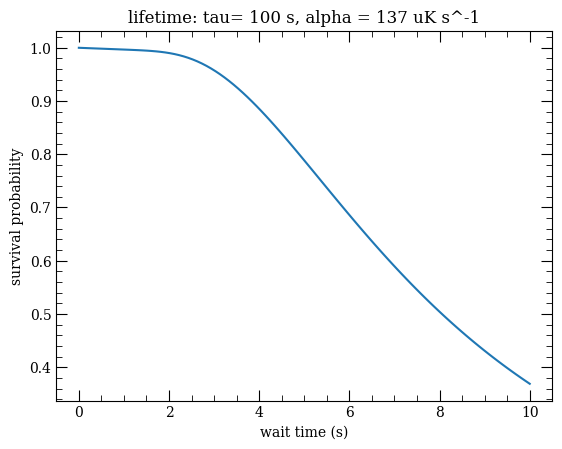

In [7]:
time= np.linspace(0,10, 100)
fig,ax = plt.subplots()
ax.plot(time,P_survival_lin_heating(time, 300, 30e-6, U0=U0_tweezer_inK, T0=10e-6) )
# ax.set_yscale('log')
ax.set_xlabel( "wait time (s)")
ax.set_ylabel("survival probability")
ax.set_title("lifetime: tau= 100 s, alpha = 137 uK s^-1")

# Monte-Carlo simulations: release-recapture

Following the procedure discussed in Tuchendler et al., 2008 Energy distribution and cooling of a single atom in an optical tweezer.

For the simulation, the initial position and velocity are chosen according to normal distributions with widths σr,v, and we consider that an atom is lost if its kinetic energy is higher than the trap potential at the atom position after the time of flight.

In [8]:
def delta_x_par (T, omega_par, mass= 87*const.u):
    return np.sqrt(const.k*T / (mass * omega_par**2) )

def delta_x_perp (T, omega_perp, mass= 87*const.u):
    return np.sqrt(const.k*T / (mass * omega_perp**2) )

def delta_v (T, mass= 87*const.u):
    return np.sqrt(const.k * T/ mass)

def get_initial_params(T, omega_par, omega_perp):
    # in here we assume that the z direction is the tweezer axis -> omega parallel
    (xi, yi)= np.random.normal(0, delta_x_perp(T, omega_perp), 2)
    zi= np.random.normal(0, delta_x_par(T, omega_par))
    (vxi, vyi, vzi) = np.random.normal(0, delta_v(T), 3)
    return (xi, yi, zi, vxi, vyi, vzi)

def get_final_params(dt, xi,yi,zi, vxi, vyi, vzi):
    g= 9.8 # m/s
    xf = xi + vxi*dt
    yf = yi + vyi*dt - (g * dt**2)/2
    zf = zi + vzi*dt
    vxf = vxi
    vyf = vyi - g*dt
    vzf = vzi

    return (xf, yf, zf, vxf, vyf, vzf )

def get_final_K_energy (xf, yf, zf, vxf, vyf, vzf, omega_par, omega_perp, mass = 87*const.u):
    return mass/2 * (vxf**2 + vyf**2 + vzf**2) + 1/2 * mass * ( (omega_par**2 * zf**2) + omega_perp**2 * (xf**2+ yf**2))



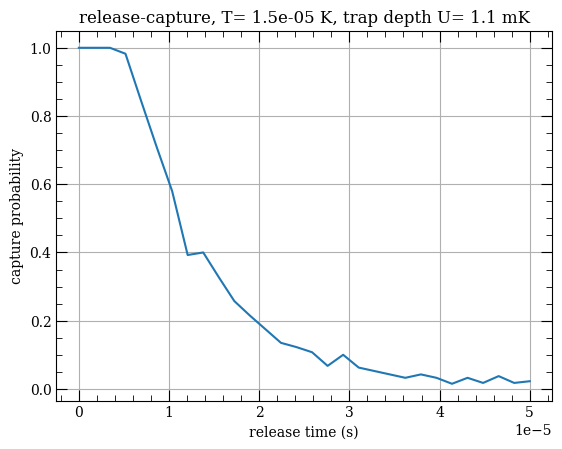

In [9]:
T= 15e-6
tweezer_depth= abs(U0_tweezer_inJ)
# tweezer_depth= const.k *1.25e-3

trajectories_per_time = 400
dts = np.linspace(0, 50e-6, 30)

surv_dts =np.zeros(len(dts))

for j in range(len(dts)):
    dt = dts[j]
    surv1 = np.zeros(trajectories_per_time)
    for i in range(trajectories_per_time):
        initial_params = get_initial_params(T, omega_par= 2*pi*omega_parallel, omega_perp= 2*pi*omega_perpendicular)
        final_params = get_final_params(dt, *initial_params)
        final_K_energy= get_final_K_energy(*final_params, omega_par= 2*pi*omega_parallel, omega_perp= 2*pi*omega_perpendicular)
        # print(final_K_energy)
        if (final_K_energy < tweezer_depth):
            surv1[i]+=1
    surv_dts[j] = surv1.mean()

fig,ax = plt.subplots()
ax.plot(dts, surv_dts)
ax.set_ylabel ("capture probability")
ax.set_xlabel ("release time (s)")
ax.set_title("release-capture, T= "+str(T)+" K, trap depth U= " + str(round(abs(U0_tweezer*const.h/const.k*1e3), 1))+" mK"  )
ax.grid()
        

In [10]:
final_params

(-3.0667869397460024e-06,
 -2.9974404437249587e-06,
 8.91106603848814e-07,
 -0.06026108094238013,
 -0.058356305740611805,
 0.017617406195244104)

# Collision with background gas

In [12]:
def maxwell_boltzmann_3D(v, T, mass):
    return (mass/(2*np.pi*const.k *T))**(3/2) * 4*np.pi*v**2 *np.exp(-mass * v**2/ (2*const.k*T))

def maxwell_boltzmann_1D(v, T, mass):
    return (mass/(2*np.pi*const.k *T))**(3/2) * v**2 *np.exp(-mass * v**2/ (2*const.k*T))

def mean_speed_MB_3D (T, mass):
    return np.sqrt(2*const.k*T/(mass))


In [13]:
mass_H2= 2*const.u
mass_N2= 2*14*const.u

H2 mean speed at 4K 182.4 m/s
H2 mean speed at 60K 706.3 m/s
H2 mean speed at 300K 1579.3 m/s


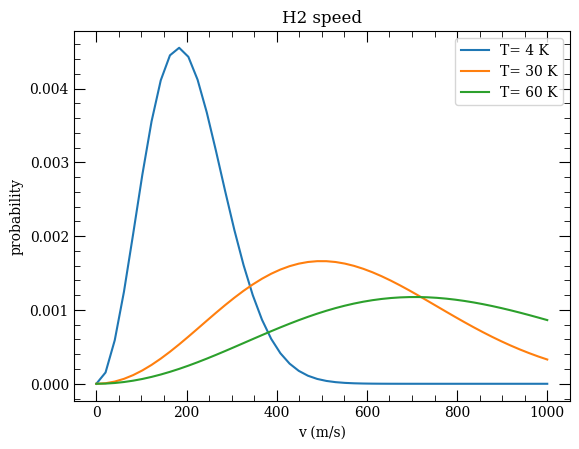

In [14]:
v= np.linspace(0,1000)

fig,ax = plt.subplots()
ax.plot(v, maxwell_boltzmann_3D(v, T=4, mass=mass_H2), label='T= 4 K')
ax.plot(v, maxwell_boltzmann_3D(v, T=30, mass=mass_H2), label='T= 30 K')
ax.plot(v, maxwell_boltzmann_3D(v, T=60, mass=mass_H2), label='T= 60 K')

ax.set_title("H2 speed")
ax.set_xlabel("v (m/s)")
ax.set_ylabel("probability")
ax.legend()
print("H2 mean speed at 4K "+str(round(mean_speed_MB_3D(T=4, mass=mass_H2),1))+" m/s"  )
print("H2 mean speed at 60K "+str(round(mean_speed_MB_3D(T=60, mass=mass_H2),1))+" m/s"  )
print("H2 mean speed at 300K "+str(round(mean_speed_MB_3D(T=300, mass=mass_H2),1))+" m/s"  )


N2 mean speed at 60K 188.8 m/s


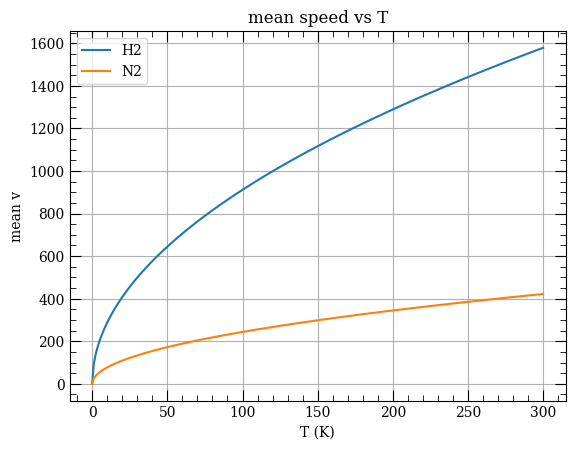

In [15]:
fig,ax = plt.subplots()
T_range= np.linspace(0,300, 300)

ax.plot(T_range, mean_speed_MB_3D(T_range, mass=mass_H2), label="H2")
ax.plot(T_range, mean_speed_MB_3D(T_range, mass=mass_N2), label="N2")

ax.set_xlabel("T (K)")
ax.set_ylabel("mean v")
ax.set_title ("mean speed vs T")
ax.legend()
ax.grid()
print("N2 mean speed at 60K "+str(round(mean_speed_MB_3D(T=60, mass=mass_N2),1))+" m/s"  )


In [16]:
# velocity gain after a collision
def v_gain(T, mass= mass_H2):
    v_average_thermal_gas= mean_speed_MB_3D(T=T, mass=mass)
    return 2*v_average_thermal_gas /(1+ mass_Rb/mass)

print("Rb v gain after H2 coollision 4K ~"+str(round(v_gain(T=4, mass=mass_H2)))+" m/s")
print("Rb v gain after H2 coollision 40K ~"+str(round(v_gain(T=40, mass=mass_H2)))+" m/s")
print("Rb v gain after N2 coollision 40K ~"+str(round(v_gain(T=40, mass=mass_N2)))+" m/s")


Rb v gain after H2 coollision 4K ~8 m/s
Rb v gain after H2 coollision 40K ~26 m/s
Rb v gain after N2 coollision 40K ~75 m/s


In [21]:
np.sqrt(2*1000*const.k/(40*const.u))

644.7659505986082

In [16]:
def boltzmann_of_T(T, T_avg):
    return 1/2 * 1/(const.k*T_avg)**3 *(T)**2 *np.exp(-T/ (const.k*T_avg))
    return 2*np.sqrt(const.k*T/(np.pi)) * (1/(const.k *T_avg))**(3/2) *np.exp(-T/ (T_avg))
    # return (mass/(2*np.pi*const.k *T_avg))**(3/2) * 12*np.pi*const.k*T/mass *np.exp(-3*T/ T_avg/2)

def p_surv(E, T_avg):
    eta= E/(const.k*T_avg)
    return 1- (1+ eta + 1/2*eta**2)*np.exp(-eta)

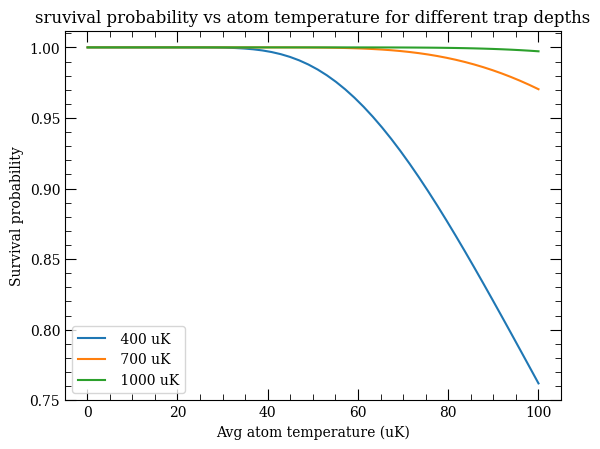

In [17]:
Ts= np.linspace(0.1e-6, 100e-6)
t_avg=60e-6
# plt.plot(Ts, boltzmann_of_T(Ts, t_avg) )
# plt.plot(Ts*1e6, p_surv(const.k*Ts, t_avg))
fig, ax =plt.subplots()
ax.plot(Ts*1e6, p_surv(const.k*400e-6, Ts), label=" 400 uK" )
ax.plot(Ts*1e6, p_surv(const.k*700e-6, Ts), label=" 700 uK" )
ax.plot(Ts*1e6, p_surv(const.k*1000e-6, Ts), label=" 1000 uK" )
ax.set_xlabel("Avg atom temperature (uK)")
ax.set_ylabel("Survival probability")
ax.set_title("sruvival probability vs atom temperature for different trap depths")
ax.legend()

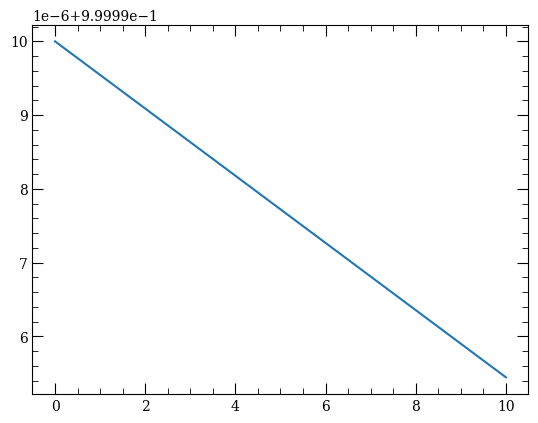

In [18]:
T_after_cooling = 15e-6 # K
heating_rate= 5e-6 # K/s 
nloops = 11
wait_time = 1 #in seconds

trap_depth = 400e-6 # K
def survival_after_loops(loops):
    survival=1
    for i in range(0, loops):
        T_end_of_cycle = T_after_cooling + heating_rate* wait_time
        survival = survival * p_surv(const.k*trap_depth,T_end_of_cycle )
    return survival

surv=[]
for i in range(0, nloops):
    surv.append(survival_after_loops(i))
plt.plot(np.arange(0,nloops),surv )

In [57]:
meas_survival=[1.   , 0.988, 0.954, 0.975, 0.938, 0.821, 0.686, 0.707, 0.574,
       0.533, 0.45 , 0.422]
meas_times = 100.0, 1000.0, 1900.0, 2800.0, 3700.0, 4600.0, 5500.0, 6400.0, 7300.0, 8200.0, 9100.0, 10000.0
meas_temperature= [15.5, 24.88, 36.9, 50.4, 55.15, 65, 56.4, 80.7, 66.2, 59, 59, 89]

In [102]:
def P_survival_pulsed_cooling(t, tau, alpha, wait_between_pulse= 1, U0= U0_tweezer_inK, T0=20e-6):
    P_vacuum = np.exp(-t/tau)

    cycles= floor(t/wait_between_pulse)
    cycles= [int(a) for a in cycles]
    extra_t= t-cycles

    surv_per_cycle = 1- np.exp(- U0/(T0 + alpha*wait_between_pulse) ) * ( 1+ U0/(T0 + alpha*wait_between_pulse) + U0**2/(2*(T0 + alpha*wait_between_pulse)**2) )
    surv=  surv_per_cycle**cycles
  
    P_heat_extra_t = 1- np.exp(- U0/(T0 + alpha*extra_t) ) * ( 1+ U0/(T0 + alpha*extra_t) + U0**2/(2*(T0 + alpha*extra_t)**2) )
    surv = surv * P_heat_extra_t
    
    return P_vacuum *surv

Text(0, 0.5, 'survival probability')

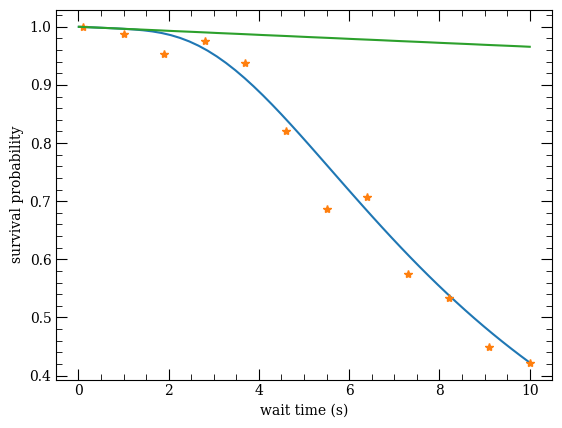

In [106]:
time= np.linspace(0.01,10)
fig,ax = plt.subplots()
ax.plot(time,P_survival_lin_heating(time, 300, 15e-6, U0=400e-6, T0=15e-6) )
ax.plot(np.array(meas_times)*1e-3,meas_survival, '*')
ax.plot(time,P_survival_pulsed_cooling(time, 300, 15e-6, wait_between_pulse= 1, U0=400e-6, T0=15e-6) )

ax.set_xlabel( "wait time (s)")
ax.set_ylabel("survival probability")
# ax.set_title("lifetime: tau= 100 s, alpha = 137 uK s^-1")

In [107]:
P_survival_pulsed_cooling(time, 300, 15e-6, wait_between_pulse= 1, U0=400e-6, T0=15e-6) 

array([0.99996667, 0.99928725, 0.99860712, 0.99791904, 0.99719685,
       0.99640798, 0.99573096, 0.99505293, 0.99436559, 0.99364015,
       0.99286196, 0.99218731, 0.99151132, 0.99082447, 0.99009521,
       0.98932856, 0.98865626, 0.98798223, 0.98729561, 0.98656194,
       0.98580773, 0.98513777, 0.9844656 , 0.98377891, 0.9830402 ,
       0.98229943, 0.98163177, 0.98096137, 0.9802743 , 0.97952989,
       0.97880361, 0.97813824, 0.97746948, 0.97678169, 0.97603088,
       0.97532023, 0.97465711, 0.97398986, 0.97330098, 0.97254303,
       0.97184925, 0.97118834, 0.97052246, 0.96983209, 0.96906623,
       0.96839062, 0.96773187, 0.9670672 , 0.9663749 , 0.96560034])

# lifetime vs vacuum pressure

$$
\gamma_i \approx 6.8 \frac{P_i}{\left(k_B T\right)^{2 / 3}}\left(\frac{C_i}{m_i}\right)^{1 / 3}\left(D m_0\right)^{-1 / 6}
$$

from https://arxiv.org/pdf/1203.0189.pdf

In [44]:
T_bkg = 300 # kelvin
mass_Rb = 87 #*const.u
# P_H2= 1e-9 #Torr
C_h2 = 137# *const.u#a.u for H2 
m_H2 = 2 #*const.u
depth = 1 #*const.k
Pa_to_Torr = 0.0075006168 

gamma= 6.8 * 1/(const.k*T_bkg)**(2/3) * (C_h2/m_H2)**(1/3) * (depth * mass_Rb)**(-1/6) 
gamma*1e-7

51248701.90744965